#Load data and function definition

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import pickle

In [ ]:
!pip install tslearn

     |████████████████████████████████| 793 kB 5.2 MB/s 


In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5 MB 4.1 MB/s 


In [ ]:
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

In [ ]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.generators import random_walks

In [ ]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

In [ ]:
from pyts.approximation import DiscreteFourierTransform

In [ ]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

In [ ]:
y_train = pd.read_fwf("y_train.txt", header = None)[0]
y_test = pd.read_fwf("y_test.txt", header = None)[0]

subject_train = pd.read_csv("subject_train.txt", header = None)[0]
subject_test = pd.read_csv("subject_test.txt", header = None)[0]

body_x = pd.read_fwf("body_acc_x_train.txt", header = None)
body_y = pd.read_fwf("body_acc_y_train.txt", header = None)
body_z = pd.read_fwf("body_acc_z_train.txt", header = None)

#acc_x = pd.read_fwf("total_acc_x_train.txt", header = None)
#acc_y = pd.read_fwf("total_acc_y_train.txt", header = None)
#acc_z = pd.read_fwf("total_acc_z_train.txt", header = None)

gyro_x = pd.read_fwf("body_gyro_x_train.txt", header = None)
gyro_y = pd.read_fwf("body_gyro_y_train.txt", header = None)
gyro_z = pd.read_fwf("body_gyro_z_train.txt", header = None)

body_x_test = pd.read_fwf("body_acc_x_test.txt", header = None)
body_y_test = pd.read_fwf("body_acc_y_test.txt", header = None)
body_z_test = pd.read_fwf("body_acc_z_test.txt", header = None)

#acc_x_test = pd.read_fwf("total_acc_x_test.txt", header = None)
#acc_y_test = pd.read_fwf("total_acc_y_test.txt", header = None)
#acc_z_test = pd.read_fwf("total_acc_z_test.txt", header = None)

gyro_x_test = pd.read_fwf("body_gyro_x_test.txt", header = None)
gyro_y_test = pd.read_fwf("body_gyro_y_test.txt", header = None)
gyro_z_test = pd.read_fwf("body_gyro_z_test.txt", header = None)

In [ ]:
with open("features.txt") as f:
    lines = f.read().splitlines()
    
features = {}
for line in lines:
    idx, name = line.split()
    features[int(idx)-1] = name

In [ ]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

In [ ]:
y_train_mapped = y_train.map(activities)
y_test_mapped = y_test.map(activities)

# Time series dataframe

Creiamo un dizionario con tutti e 6 i dataframe: body_x, body_y, body_z, gyro_x, gyro_y, gyro_z. Per ognuno di questi dataframe andiamo poi a prenderci solamente le prime 64 colonne (letture). Dobbiamo però considerare che, così facendo, le letture che vanno dalla 64esima alla 127esima colonna dell'ultima riga di ciascun dataframe verrebbero perse. Per tale motivo, prendiamo l'ultima riga per intero. Più precisamente, con le ultime 64 letture dell'ultima riga andiamo a crearci una nuova riga. Alla fine, ciascun dataset non avrà più 7352 righe, bensì 7353.

In [ ]:
dict_dfs = {'body_x': body_x,
            'body_y': body_y,
            'body_z': body_z,
            #'acc_x' : acc_x,
            #'acc_y' : acc_y,
            #'acc_z' : acc_z,
            'gyro_x': gyro_x,
            'gyro_y': gyro_y,
            'gyro_z': gyro_z}

for name_df, df in dict_dfs.items():
    last_row = df.iloc[-1:,64:]
    last_row.columns = np.arange(64) # rename columns of the last raw
    first64 = df.iloc[:,:64]
    dict_dfs[name_df] = pd.concat([first64, last_row], ignore_index=True)
    # aggiungiamo anche le colonne ID soggetto e tipo di attività svolta
    dict_dfs[name_df]['subject'] = subject_train
    dict_dfs[name_df]['activity'] = y_train_mapped
    dict_dfs[name_df].iloc[-1, -2:] = dict_dfs[name_df].iloc[-2, -2:]
    dict_dfs[name_df]['subject'] = dict_dfs[name_df]['subject'].astype(int)


In [ ]:
dict_dfs_test = {'body_x_test': body_x_test,
                 'body_y_test': body_y_test,
                 'body_z_test': body_z_test,
                 #'acc_x_test': acc_x_test,
                 #'acc_y_test': acc_y_test,
                 #'acc_z_test': acc_z_test,
                 'gyro_x_test': gyro_x_test,
                 'gyro_y_test': gyro_y_test,
                 'gyro_z_test': gyro_z_test}

for name_df, df in dict_dfs_test.items():
    last_row = df.iloc[-1:,64:]
    last_row.columns = np.arange(64) # rename columns of the last raw
    first64 = df.iloc[:,:64]
    dict_dfs_test[name_df] = pd.concat([first64, last_row], ignore_index=True)
    # aggiungiamo anche le colonne ID soggetto e tipo di attività svolta
    dict_dfs_test[name_df]['subject'] = subject_test
    dict_dfs_test[name_df]['activity'] = y_train_mapped
    dict_dfs_test[name_df].iloc[-1, -2:] = dict_dfs_test[name_df].iloc[-2, -2:]
    dict_dfs_test[name_df]['subject'] = dict_dfs_test[name_df]['subject'].astype(int)
    
                
#df_ts_test = pd.DataFrame(dict_dfs_ts_test)


In [ ]:
# code derived from https://pyts.readthedocs.io/en/stable/auto_examples/approximation/plot_dft.html
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

#Classic TS Cluster

##concatenate a 64

###KMeans

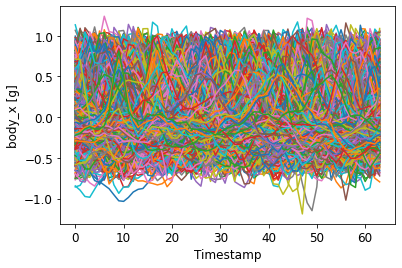

In [ ]:
file = [body_x, body_y, body_z, gyro_x, gyro_y, gyro_z]
X_train = list()
for df in file:
    X_train.append(df.values[:, :, np.newaxis])
X_train = np.concatenate(X_train, axis=2)
X_train = np.array(X_train)
df_train=dict_dfs['body_x']
df_train = df_train.iloc[:, :-2]
X_train_64=df_train.values

plt.plot(X_train_64.T)

plt.xlabel('Timestamp')
plt.ylabel('body_x [g]')
plt.savefig('X_64.pdf', bbox_inches = 'tight')

plt.show()

In [ ]:
sil_array=[]
for i in range(3,70):
  km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=1, random_state=0)
  km.fit(X_train_64)
  labels=km.labels_
  sil=silhouette_score(X_train_64, labels, metric="euclidean")  # doctest: +ELLIPSIS
  sil_array.append(sil)
  print(i,sil)

3 0.4498180871200156
4 0.4704065270251151
5 0.47798895635652183
6 0.4675359591755608
7 0.47237834028953
8 0.49040825726822834
9 0.4937342124492849
10 0.4951415649245875
11 0.49587067852399014
12 0.49684770349577795
13 0.500844987758264
14 0.5015992855131807
15 0.5035101394014198
16 0.5072391500401812
17 0.5073773023468978
18 0.5078016477062486
19 0.5082429480546606
20 0.5090063346745228
21 0.5073783867335887
22 0.5078116523875146
23 0.50889678952684
24 0.5109228423275303
25 0.5123926750876983
26 0.5142995204225594
27 0.5148795722449101
28 0.5157125323044537
29 0.5168558447187525
30 0.5179399779691825
31 0.5188245107490675
32 0.5190382266932599
33 0.5186282570350449
34 0.5192461828887627
35 0.5201326840868347
36 0.5208169450060056
37 0.52122715211068
38 0.5213166308407402
39 0.521455180567227
40 0.5217747820008334
41 0.5220412275515433
42 0.5216814967212319
43 0.5216352953013614
44 0.5207229830804876
45 0.5214690380427548
46 0.521982765411532
47 0.5222552690946811
48 0.5226041925229091


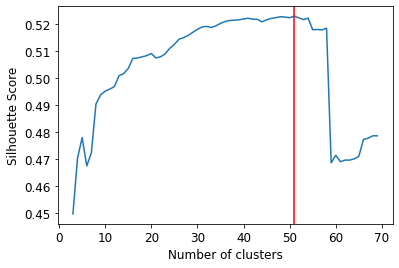

In [ ]:
plt.plot(np.linspace(3,69,67),sil_array)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.axvline(x = 51, color='r', label = 'maximum')
plt.savefig('X_64_silhouette_euc.pdf', bbox_inches = 'tight')

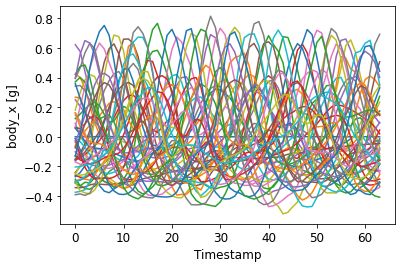

In [ ]:
km = TimeSeriesKMeans(n_clusters=51, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_train_64)

plt.plot(np.squeeze(km.cluster_centers_).T)
plt.xlabel('Timestamp')
plt.ylabel('body_x [g]')
plt.savefig('X_64_51_cluster.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
sil_array=[]
for i in range(3,50):
  km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=1, random_state=0)
  km.fit(X_train_64)
  labels=km.labels_
  sil=silhouette_score(X_train_64, labels, metric="euclidean")  # doctest: +ELLIPSIS
  sil_array.append(sil)
  print(i,sil)

3 0.41532099493554225
4 0.414776114281421
5 0.4170086074904086
6 0.4218510118237996
7 0.4216661882889222
8 0.42993306386304353
9 0.43261127118626813
10 0.4320398917657054
11 0.43249955352792835
12 0.42219985721016795
13 0.4233726430646888
14 0.42434714311365107
15 0.42683498799528213
16 0.42845329529226844
17 0.4271375661911156
18 0.42827873115868054
19 0.43298688835219246
20 0.43296398941254055
21 0.4192454939966368
22 0.4219335217486898
23 0.42382768569745144
24 0.42389619056769234
25 0.4232095179415183
26 0.4243341629445099
27 0.4268375303510368
28 0.42574731787565473
29 0.4253732383948402
30 0.42649354577393084


KeyboardInterrupt: ignored

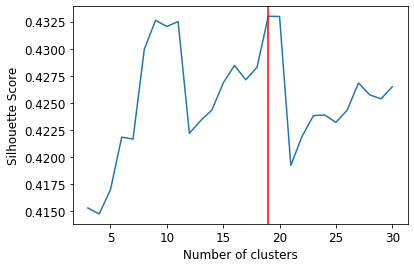

In [ ]:
plt.plot(np.linspace(3,30,28),sil_array)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.axvline(x = 19, color='r', label = 'maximum')

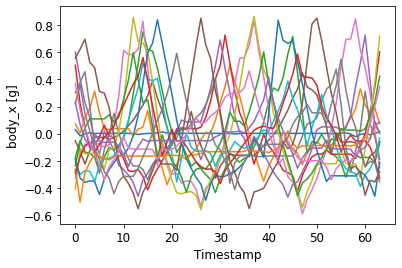

In [ ]:
km = TimeSeriesKMeans(n_clusters=18, metric="dtw", max_iter=5, random_state=0)
km.fit(X_train_64)

plt.plot(np.squeeze(km.cluster_centers_).T)
plt.xlabel('Timestamp')
plt.ylabel('body_x [g]')
plt.savefig('X_64_18_cluster_dtw.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
km_dtw = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X_train_64)

labels=km_dtw.labels_
print(silhouette_score(X_train_64, labels, metric="euclidean")) 

0.4256906631392968


##Approximated KMeans

In [ ]:
#PIECEWISE


n_paa_segments =10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X_train_64)

#plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
#plt.show()

#km = TimeSeriesKMeans(n_clusters=9, metric="euclidean", max_iter=5, random_state=0)
#km.fit(X_paa)
#
#plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 9))
#plt.show()

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 7353 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [ ]:
sil_array=[]
for i in range(3,36):
  km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=1, random_state=0)
  km.fit(X_paa)
  labels=km.labels_
  sil=silhouette_score(X_paa, labels, metric="euclidean")  # doctest: +ELLIPSIS
  sil_array.append(sil)
  print(i,sil)

3 0.4337866687941024
4 0.4484868709083139
5 0.45366723200815307
6 0.45807115603994775
7 0.4594043767738838
8 0.44918116590144613
9 0.4515314048603441
10 0.45148814856552233
11 0.4523856985632774
12 0.45061025199391613
13 0.44880771992485124
14 0.44801666985205113
15 0.44900680164788465
16 0.4485526920803362
17 0.443696739825437
18 0.4446664282319929
19 0.44651992004011914
20 0.44533655572109077
21 0.46440093589771464
22 0.454845803140858
23 0.4542632627322967
24 0.45307028020828904
25 0.4543797304994867
26 0.4537048419651103
27 0.4548609916284349
28 0.4541513694018673
29 0.455458307064028
30 0.45553999476529017
31 0.45418455665457586
32 0.4562167817807187
33 0.45557104810782884
34 0.4557064156597238
35 0.45518858097543424
36 0.45699729870042427


KeyboardInterrupt: ignored

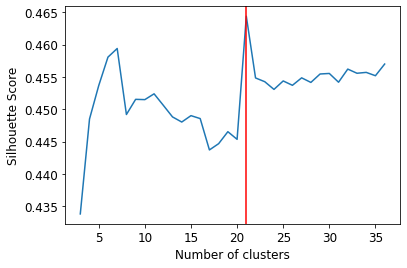

In [ ]:
plt.plot(np.linspace(3,36,34),sil_array)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.axvline(x = 21, color='r', label = 'maximum')

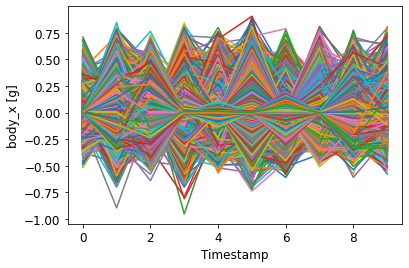

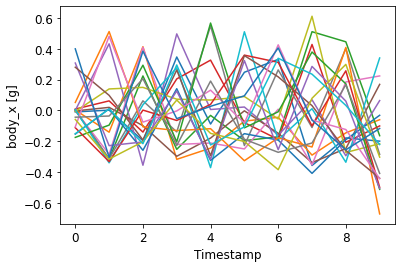

In [ ]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.xlabel('Timestamp')
plt.ylabel('body_x [g]')
plt.savefig('X_PAA.pdf', bbox_inches = 'tight')
plt.show()

km = TimeSeriesKMeans(n_clusters=21, metric="dtw", max_iter=1, random_state=0)
km.fit(X_paa)

plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 21))
plt.xlabel('Timestamp')
plt.ylabel('body_x [g]')
plt.savefig('X_PAA_21_cluster.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# SAX transform
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(X_train_64)



/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 7353 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [ ]:
sil_array=[]
for i in range(2,20):
  km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=1, random_state=0)
  km.fit(ts_sax)
  labels=km.labels_
  sil=silhouette_score(ts_sax, labels, metric="euclidean")  # doctest: +ELLIPSIS
  sil_array.append(sil)
  print(i,sil)

2 0.02938283325220398
3 0.05728486932844198
4 0.04774385793219517
5 0.02396547622672893
6 0.03234435218841312
7 0.01363947438811949
8 -0.029401368757008498
9 -0.0055769131894307725
10 -0.0034380521301813328
11 -0.0008540097405361557
12 0.00032454817931961934
13 -0.012922055754251762
14 -0.014405463568450032
15 -0.011041683029314504
16 -0.007469506642795449
17 -0.0075361525869809655
18 -0.007562424279174267
19 -0.006973678038022973


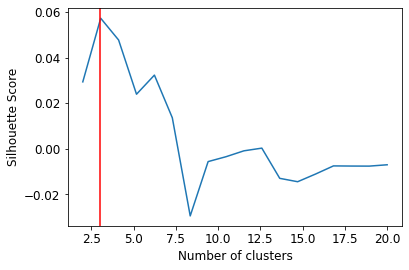

In [ ]:
plt.plot(np.linspace(2,20,18),sil_array)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.axvline(x = 3, color='r', label = 'maximum')

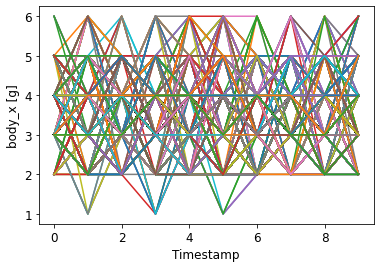

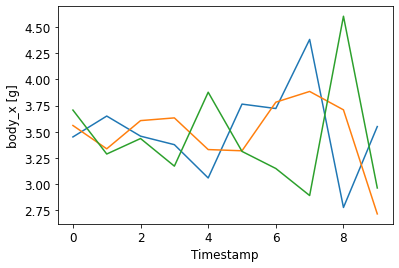

In [ ]:
plt.plot(ts_sax.reshape(ts_sax.shape[1], ts_sax.shape[0]))
plt.xlabel('Timestamp')
plt.ylabel('body_x [g]')
plt.savefig('X_SAX.pdf', bbox_inches = 'tight')
plt.show()

km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=1, random_state=0)
km.fit(ts_sax)

plt.plot(km.cluster_centers_.reshape(ts_sax.shape[1], 3))
plt.xlabel('Timestamp')
plt.ylabel('body_x [g]')
plt.savefig('X_SAX_3_cluster.pdf', bbox_inches = 'tight')
plt.show()

#64 non concatenate, multidimensionali

In [ ]:
file = [body_x, body_y, body_z,  gyro_x, gyro_y, gyro_z]
X_train = list()
for df in file:
    X_train.append(df.values[:, :, np.newaxis])
X_train = np.concatenate(X_train, axis=2)
X_train = np.array(X_train)

In [ ]:
X_train.shape

(7352, 128, 6)

In [ ]:
km_dtw = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X_train)
clus_test=np.squeeze(km_dtw.cluster_centers_)
labels=km_dtw.labels_

In [ ]:
silhouette_score(X_train, labels, metric="euclidean")  # doctest: +ELLIPSIS

0.34358940478232647

#DTW fra train e test per singoli cluster

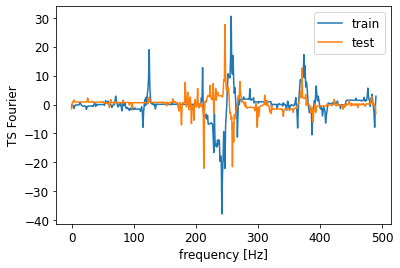

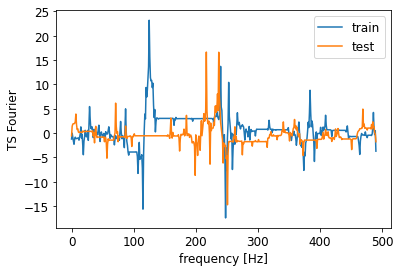

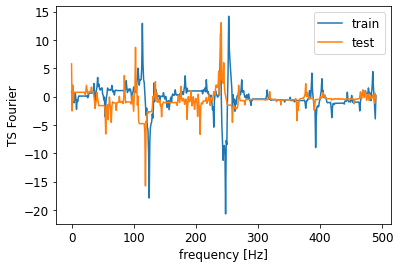

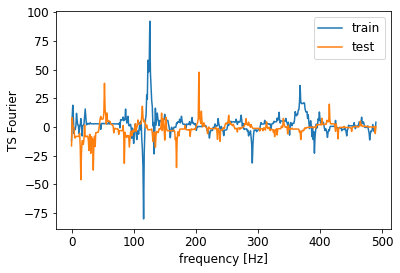

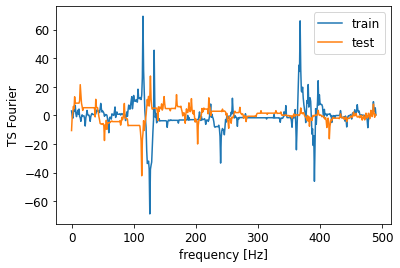

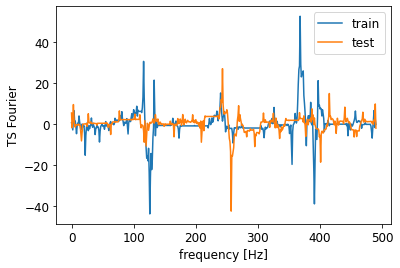

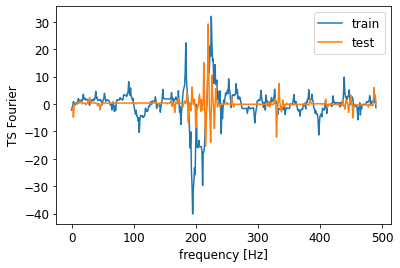

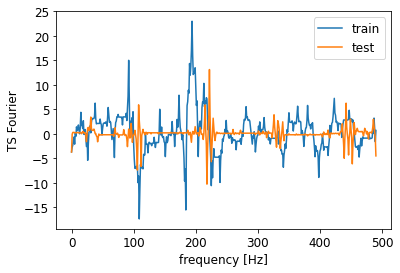

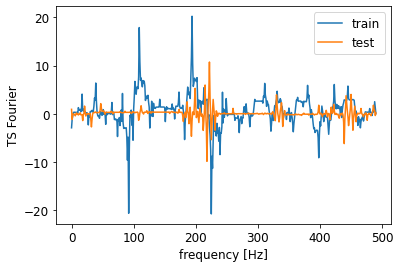

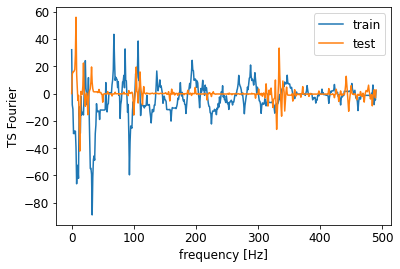

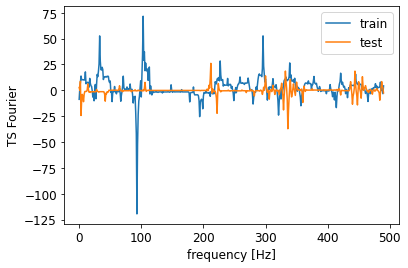

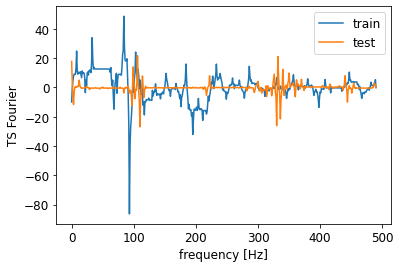

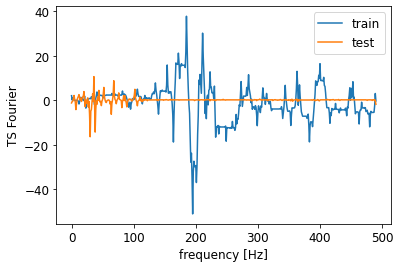

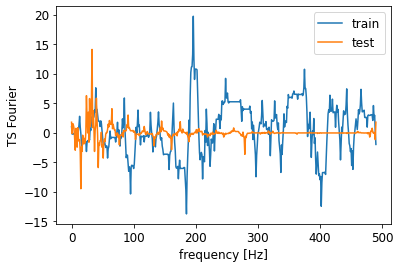

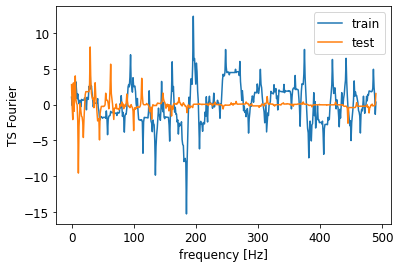

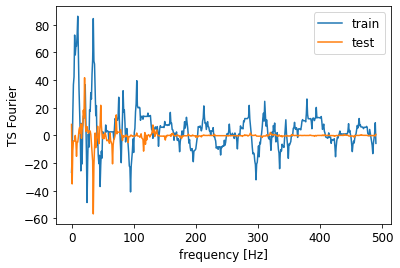

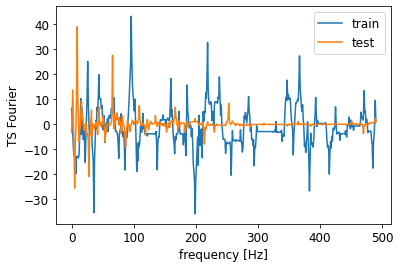

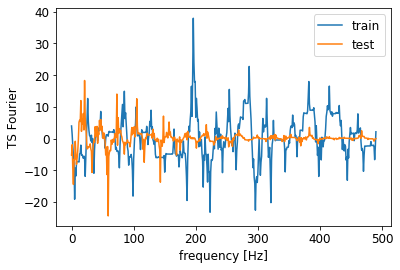

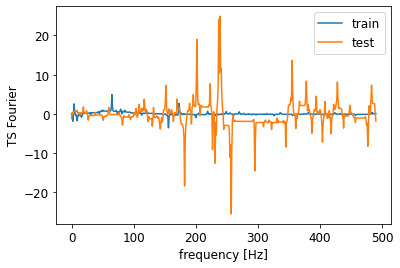

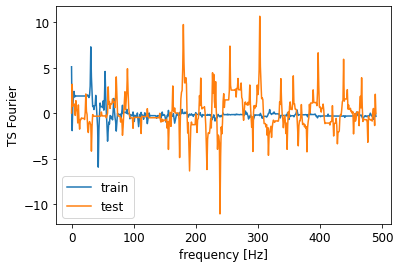

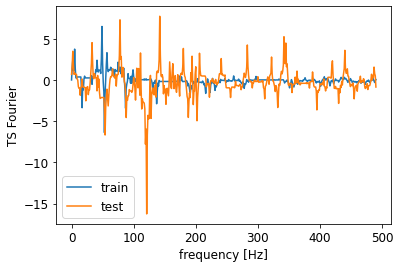

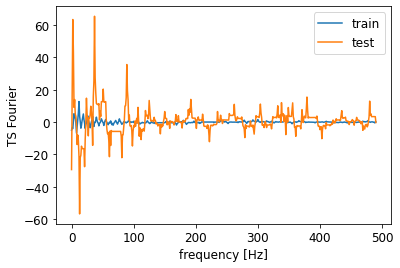

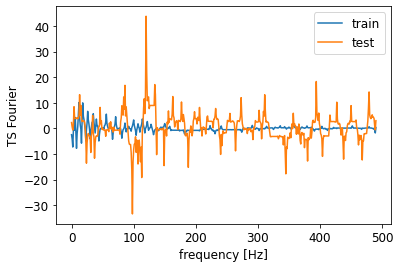

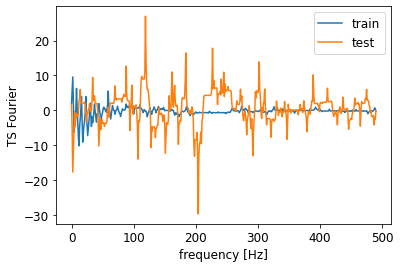

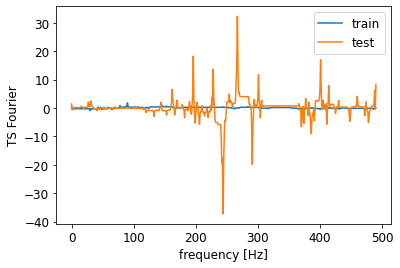

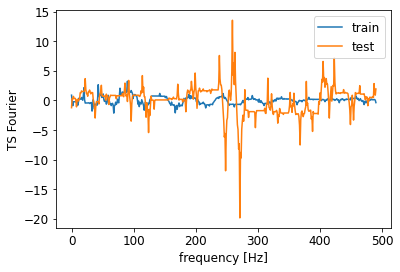

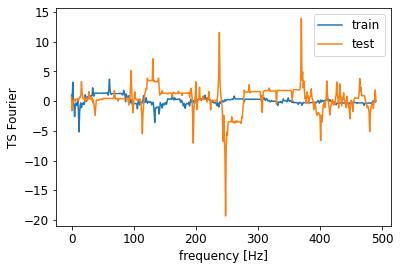

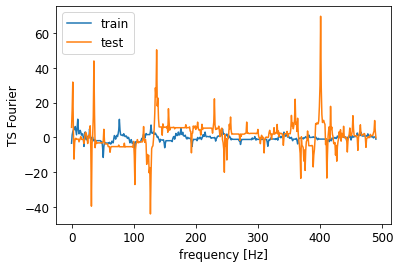

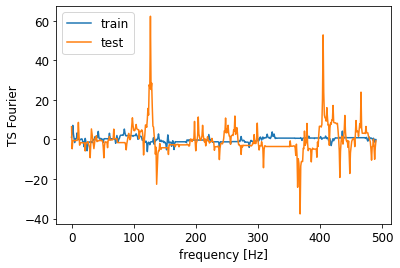

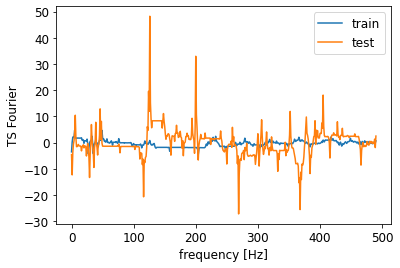

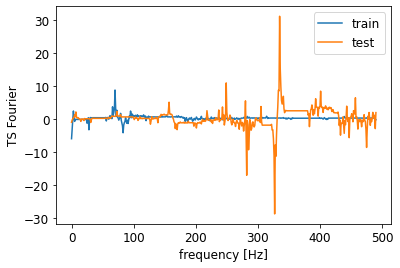

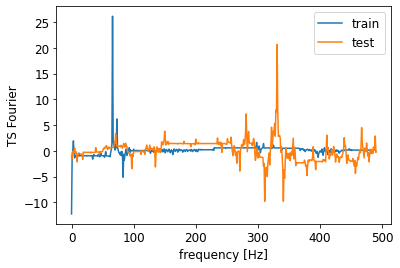

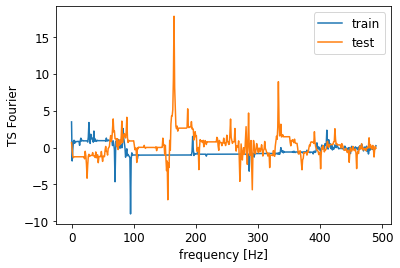

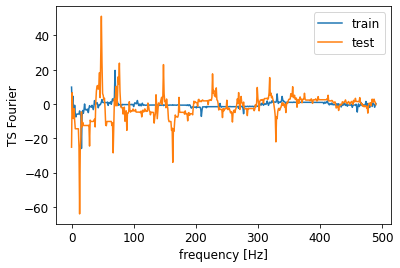

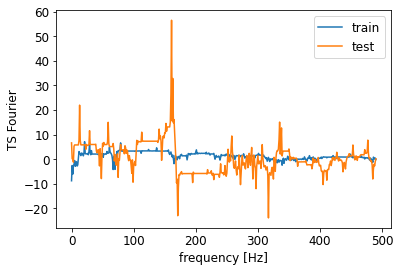

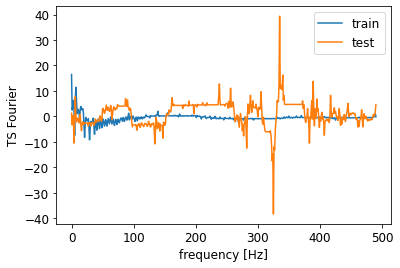

In [ ]:
#act='WALKING'
windows = 10

n_coefs = 500

dft = DiscreteFourierTransform(n_coefs=n_coefs)

dtw_arr_tot=[]

for act in [activities[k] for k in range(1,7)]: 
  dtw_array=[]
  for name_df,df in dict_dfs.items():
    X_train=[]
    X_test=[]
    temp_train=df
    temp_test=dict_dfs_test[name_df+'_test']
    #temp_train=clean_dataset(temp_train)
    #temp_test=clean_dataset(temp_test)
    temp1_train=temp_train.loc[temp_train['activity']==act]
    temp1_test=temp_test.loc[temp_test['activity']==act]

    for subject in subject_train.unique():
      temp2 = temp1_train.loc[temp1_train['subject']==subject]
      temp2 = temp2.iloc[:,:-2]
      temp2 = clean_dataset(temp2)
      ts1 = temp2.values.ravel()
      ts = dft.fit_transform(ts1.reshape(1, -1))
      #ts = dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=len(ts))
      ts=ts.ravel()
      ts=pd.Series(ts - ts.mean()/ts.std()).rolling(windows).mean()[windows-1:]
      ts=np.array(ts.ravel())
      X_train.append(ts)

    for subject in subject_test.unique():
      temp2=temp1_test.loc[temp1_test['subject']==subject]
      temp2=temp2.iloc[:,:-2]
      temp2=clean_dataset(temp2)
      ts=temp2.values.ravel()
      ts = dft.fit_transform(ts.reshape(1, -1))
      #ts = dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=len(ts))
      ts=ts.ravel()
      ts=pd.Series(ts - ts.mean()/ts.std()).rolling(windows).mean()[windows-1:]
      ts=np.array(ts.ravel())
      X_test.append(ts)



    df_X_train = pd.DataFrame(X_train)
    cluster_train=df_X_train.values

    df_X_test = pd.DataFrame(X_test)
    cluster_test=df_X_test.values

    km_dtw = TimeSeriesKMeans(n_clusters=1, metric="dtw", max_iter=50, random_state=0)
    km_dtw.fit(cluster_train)

    clus_train=np.squeeze(km_dtw.cluster_centers_)


    km_dtw = TimeSeriesKMeans(n_clusters=1, metric="dtw", max_iter=50, random_state=0)
    km_dtw.fit(cluster_test)

    clus_test=np.squeeze(km_dtw.cluster_centers_)

    plt.plot(clus_train.T,label='train')
    plt.plot(clus_test.T,label='test')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('TS Fourier')
    plt.legend()
    #plt.savefig('confront/'+name_df+'_'+act+'.pdf', bbox_inches='tight')

    #plt.title(name_df+' '+act)

    plt.show()

    temp_dtw=dtw(clus_train,clus_test)
    dtw_array.append(temp_dtw)
  dtw_arr_tot.append(dtw_array)


In [ ]:
!zip -r /content/conf.zip /content/confront

  adding: content/confront/ (stored 0%)
  adding: content/confront/gyro_x_WALKING_DOWNSTAIRS.pdf (deflated 20%)
  adding: content/confront/gyro_x_SITTING.pdf (deflated 20%)
  adding: content/confront/gyro_x_LAYING.pdf (deflated 21%)
  adding: content/confront/gyro_z_SITTING.pdf (deflated 20%)
  adding: content/confront/gyro_x_WALKING_UPSTAIRS.pdf (deflated 20%)
  adding: content/confront/gyro_y_WALKING_UPSTAIRS.pdf (deflated 21%)
  adding: content/confront/body_y_LAYING.pdf (deflated 21%)
  adding: content/confront/gyro_z_WALKING.pdf (deflated 21%)
  adding: content/confront/gyro_z_STANDING.pdf (deflated 21%)
  adding: content/confront/body_y_WALKING_UPSTAIRS.pdf (deflated 20%)
  adding: content/confront/body_x_WALKING.pdf (deflated 21%)
  adding: content/confront/body_z_SITTING.pdf (deflated 20%)
  adding: content/confront/body_x_WALKING_UPSTAIRS.pdf (deflated 20%)
  adding: content/confront/gyro_y_LAYING.pdf (deflated 21%)
  adding: content/confront/gyro_y_WALKING.pdf (deflated 21%)


In [ ]:
from google.colab import files
files.download("/content/conf.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
to_df=np.array(dtw_arr_tot)

In [ ]:
df_ao=pd.DataFrame(dtw_arr_tot,index=[activities[k] for k in range(1,7)],columns=['body_x','body_y','body_z','gyro_x','gyro_y','gyro_z'])

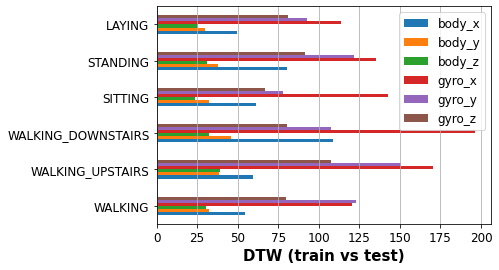

In [ ]:
ax = df_ao.plot.barh()
ax.set_xlabel('DTW (train vs test)', fontweight ='bold', fontsize = 15)
ax.grid(True,axis='x')
ax.figure.savefig('histo_act_dtw.pdf', bbox_inches = 'tight')

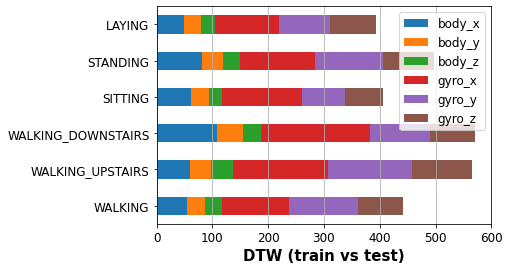

In [ ]:
#fig = plt.subplots(figsize =(12, 8))
df_ao.plot.barh(stacked=True)
#plt.style.use('ggplot')
#plt.ylabel('Feature', fontweight ='bold', fontsize = 15)
plt.xlabel('DTW (train vs test)', fontweight ='bold', fontsize = 15)
#plt.yticks([r + 2*barWidth for r in range(len(dtw_arr_tot[0]))],
#		['body_x','body_y','body_z','acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z'])
plt.grid(axis = 'x')
plt.legend()

plt.savefig('histo_act.pdf', bbox_inches = 'tight')

plt.show()

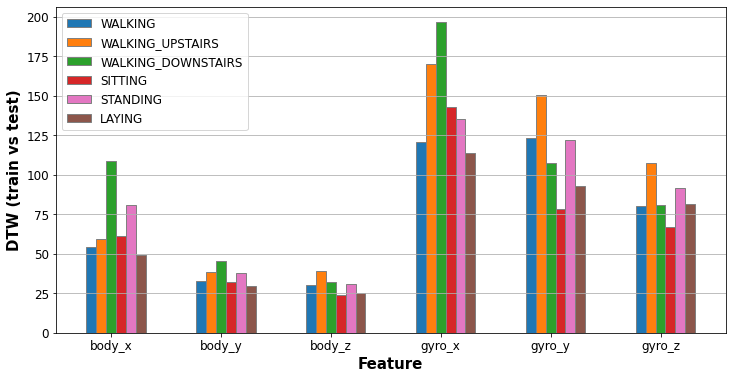

In [ ]:
# set width of bar
barWidth = 0.09
fig = plt.subplots(figsize =(12, 6))


# Set position of bar on X axis
br1 = np.arange(len(dtw_arr_tot[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]
#br7 = [x + barWidth for x in br6]
#br8 = [x + barWidth for x in br7]
#br9 = [x + barWidth for x in br8]

# Make the plot
plt.bar(br1, dtw_arr_tot[0], color ='tab:blue', width = barWidth,
		edgecolor ='grey', label ='WALKING')

plt.bar(br2, dtw_arr_tot[1], color ='tab:orange', width = barWidth,
		edgecolor ='grey', label ='WALKING_UPSTAIRS')

plt.bar(br3, dtw_arr_tot[2], color ='tab:green', width =barWidth,
		edgecolor ='grey', label ='WALKING_DOWNSTAIRS')

plt.bar(br4, dtw_arr_tot[3], color ='tab:red', width = barWidth,
		edgecolor ='grey', label ='SITTING')

plt.bar(br5, dtw_arr_tot[4], color ='tab:pink', width = barWidth,
		edgecolor ='grey', label ='STANDING')

plt.bar(br6, dtw_arr_tot[5], color ='tab:brown', width = barWidth,
		edgecolor ='grey', label ='LAYING')

# Adding Xticks
plt.xlabel('Feature', fontweight ='bold', fontsize = 15)
plt.ylabel('DTW (train vs test)', fontweight ='bold', fontsize = 15)
plt.xticks([r + 2*barWidth for r in range(len(dtw_arr_tot[0]))],
		['body_x','body_y','body_z','gyro_x','gyro_y','gyro_z'])
plt.grid(axis = 'y')
plt.legend()
plt.savefig('histo_feat.pdf', bbox_inches = 'tight')
plt.show()


#K means multidimensionale

In [ ]:
dict_dfs_ts = {name_df: [] for name_df in dict_dfs}
dict_dfs_ts['subject'] = []
dict_dfs_ts['activity'] = []
for name_df, df in dict_dfs.items():
    for subject in subject_train.unique():
        for activity in [activities[k] for k in range(1,7)]: 
            mask = (df['activity'] == activity) & (df['subject'] == subject)
            time_series = df.iloc[mask.values, :-2].values.ravel()
            dict_dfs_ts[name_df].append(time_series)
            # all'ultima iterazione del lool più esterno ci salviamo anche
            # gli ID dei soggetti e le attività nell'ordine di comparizione
            if name_df == 'gyro_z':
                dict_dfs_ts['subject'].append(subject) 
                dict_dfs_ts['activity'].append(activity)

df_ts = pd.DataFrame(dict_dfs_ts)

In [ ]:
windows = 10

n_coefs = 500

dft = DiscreteFourierTransform(n_coefs=n_coefs)

X_train=[] #dimensioni: (105,max(TS),6)
X_test=[]
X_prova=[]

for name_df,df in dict_dfs.items():
  X_train_feat=[] #qua dentro ci vanno una cosa (105,max(TS))
  X_test_feat=[]

  for act in [activities[k] for k in range(1,7)]: 

    X_train_act=[] #qua ci va (21,max(TS)), devo concatenarli uno dopo l'altro
    X_test_act=[]
    temp_train=df
    temp_test=dict_dfs_test[name_df+'_test']

    temp1_train=temp_train.loc[temp_train['activity']==act]
    temp1_test=temp_test.loc[temp_test['activity']==act]

    for subject in subject_train.unique():
      temp2=temp1_train.loc[temp1_train['subject']==subject]
      temp2=temp2.iloc[:,:-2]
      temp2=clean_dataset(temp2)
      ts=temp2.values.ravel()
      ts=ts.ravel()
      #ts=pd.Series(ts - ts.mean()/ts.std()).rolling(windows).mean()[windows-1:]
      #ts=ts.ravel()
      ts = dft.fit_transform(ts.reshape(1, -1))
      #ts = dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=len(ts))
      ts=ts.ravel()
      ts=pd.Series(ts - ts.mean()/ts.std()).rolling(windows).mean()[windows-1:]
      ts=np.array(ts.ravel())
      X_train_act.append(ts)

    for subject in subject_test.unique():
      temp2=temp1_test.loc[temp1_test['subject']==subject]
      temp2=temp2.iloc[:,:-2]
      temp2=clean_dataset(temp2)
      ts=temp2.values.ravel()
      ts=ts.ravel()
      #ts=pd.Series(ts - ts.mean()/ts.std()).rolling(windows).mean()[windows-1:]
      #ts=ts.ravel()
      ts = dft.fit_transform(ts.reshape(1, -1))
      ts=ts.ravel()
      ts=pd.Series(ts - ts.mean()/ts.std()).rolling(windows).mean()[windows-1:]
      #ts = dft_inverse_trasform(ts_dft, n_coefs=n_coefs, n_timestamps=len(ts))
      ts=np.array(ts.ravel())
      X_test_act.append(ts)
    X_train_feat.append(X_train_act)
    X_test_feat.append(X_test_act)
  X_train_feat=[j for sub in X_train_feat for j in sub]
  X_test_feat=[j for sub in X_test_feat for j in sub]
  X_prova_feat=np.append(X_train_feat,X_test_feat,axis=0)
  X_train.append(X_train_feat)
  X_test.append(X_test_feat)
  X_prova.append(X_prova_feat)

X_train=np.array(X_train)
X_test=np.array(X_test)
X_prova=np.array(X_prova)
#df_X_train = pd.DataFrame(X_train_act)
#cluster_train=df_X_train.values
#df_X_test = pd.DataFrame(X_test_act)
#cluster_test=df_X_test.values

In [ ]:
X_prova=X_prova.transpose(1,2,0)

In [ ]:
X_prova.shape

(180, 491, 6)

In [ ]:
X_test=X_test.transpose(1,2,0)

In [ ]:
X_train=X_train.transpose(1,2,0)

In [ ]:
km_dtw = TimeSeriesKMeans(n_clusters=6, metric="dtw", max_iter=50, random_state=0)
km_dtw.fit(X_prova)
clus_test=np.squeeze(km_dtw.cluster_centers_)
labels=km_dtw.labels_

In [ ]:
silhouette_score(X_prova, labels, metric="dtw")  # doctest: +ELLIPSIS

0.30581536133541665

In [ ]:
w=labels[0::6]
wu=labels[1::6]
wd=labels[2::6]
st=labels[3::6]
si=labels[4::6]
l=labels[5::6]

In [ ]:
unique, counts = np.unique(w, return_counts=True)
wal=dict(zip(unique, counts))
wal_name = list(wal.keys())
wal_value = list(wal.values())


unique, counts = np.unique(wu, return_counts=True)
walup=dict(zip(unique, counts))
walup_name = list(wal.keys())
walup_value = list(wal.values())


unique, counts = np.unique(wd, return_counts=True)
waldo=dict(zip(unique, counts))
waldo_name = list(wal.keys())
waldo_value = list(wal.values())

unique, counts = np.unique(st, return_counts=True)
sta=dict(zip(unique, counts))
sta_name = list(wal.keys())
sta_value = list(wal.values())


unique, counts = np.unique(si, return_counts=True)
sit=dict(zip(unique, counts))
sit_name = list(wal.keys())
sit_value = list(wal.values())


unique, counts = np.unique(l, return_counts=True)
lay=dict(zip(unique, counts))
lay_name = list(wal.keys())
lay_value = list(wal.values())



In [ ]:
waldo

{1: 20, 2: 1, 4: 8, 5: 1}

In [ ]:
sit

{0: 1, 1: 20, 3: 1, 4: 8}

In [ ]:
sta

{0: 1, 1: 22, 4: 7}

In [ ]:
lay

{0: 1, 1: 20, 2: 1, 4: 7, 5: 1}

In [ ]:
d = {'WALKING': [2,21,1,0,6,0], 
     'WALKING UPSTAIRS': [1,22,0,0,5,2],
     'WALKING_DOWNSTAIRS': [20,0,1,0,8,1],
     'SITTING': [1,20,0,1,8,0],
     'STANDING': [1,22,0,0,7,0],
     'LAYING': [1,20,1,0,7,1]
     }

df_vert = pd.DataFrame(data=d)
df_tra=df_vert.T

In [ ]:
#fig = plt.subplots(figsize =(12, 8))
df_tra.plot.barh(stacked=True)
#plt.style.use('ggplot')
#plt.ylabel('Activities', fontweight ='bold', fontsize = 15)
plt.xlabel('Activities in cluster', fontweight ='bold', fontsize = 15)
#plt.yticks([r + 2*barWidth for r in range(len(dtw_arr_tot[0]))],
#		['body_x','body_y','body_z','acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z'])

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=6)
plt.grid(axis='x')
plt.savefig('histo_activity_cluster.pdf', bbox_inches = 'tight')
plt.show()

NameError: ignored

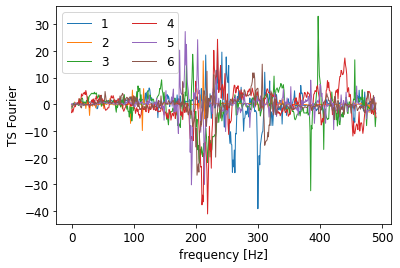

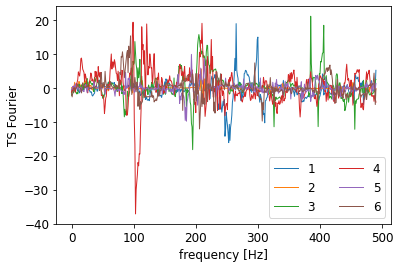

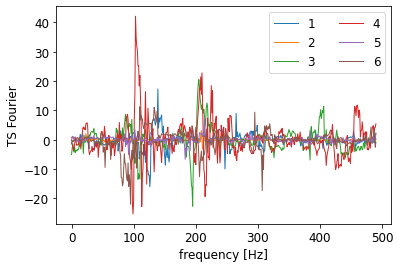

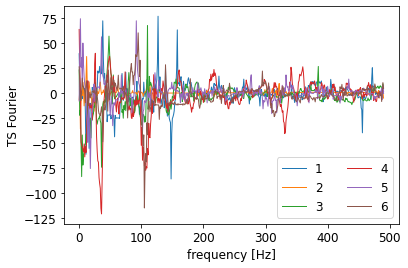

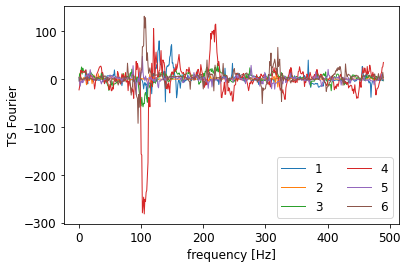

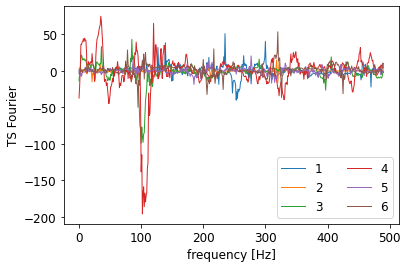

In [ ]:
nomi_var=['body_x','body_y','body_z','gyro_x','gyro_y','gyro_z']

for index,name_df in enumerate(nomi_var):

  plt.plot(clus_test[0,:,index],label='1',linewidth=1)
  plt.plot(clus_test[1,:,index],label='2',linewidth=1)
  plt.plot(clus_test[2,:,index],label='3',linewidth=1)
  plt.plot(clus_test[3,:,index],label='4',linewidth=1)
  plt.plot(clus_test[4,:,index],label='5',linewidth=1)
  plt.plot(clus_test[5,:,index],label='6',linewidth=1)
  plt.legend(ncol=2)
  plt.xlabel('frequency [Hz]')
  plt.ylabel('TS Fourier')
  
  plt.savefig('cluster_'+name_df+'.pdf', bbox_inches = 'tight')
  plt.show()